# Rating classification

### librerie

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MultiLabelBinarizer 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.tree._tree import TREE_LEAF

In [4]:
import scipy
print(scipy.__version__)

1.13.1


In [5]:
#Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

#nn vanno
# from numpy import interp
# from scikitplot.metrics import plot_roc
# from scikitplot.metrics import plot_precision_recall

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

## Pulizia test e train per sicurezza

In [8]:
dft= pd.read_csv('dfpulito.csv', skipinitialspace= True )
dft.head()
#dft.info()
test= pd.read_csv('test_pulito.csv', skipinitialspace= True)
#test.head()

In [9]:
# Conta i valori distinti
unique, counts = np.unique(dft['rating'], return_counts=True)

# Combina i valori distinti e le loro frequenze
result = dict(zip(unique, counts))
print(result)

{1: 5, 2: 62, 3: 154, 4: 466, 5: 1151, 6: 2787, 7: 4562, 8: 4817, 9: 2067, 10: 345}


In [10]:
#riportaretitletype a classe

# Dizionario inverso per la mappatura di 'titleType'
unique_title_types = ['tvEpisode', 'videoGame', 'movie', 'tvSeries', 'video', 'tvMiniSeries', 'short', 'tvMovie', 'tvSpecial', 'tvShort']
title_type_mapping = {title: i + 1 for i, title in enumerate(unique_title_types)}
reverse_title_type_mapping = {v: k for k, v in title_type_mapping.items()}

# Sostituisci i numeri di 'titleType' con i valori originali

dft['titleType'] = dft['titleType'].map(reverse_title_type_mapping)
#dft.head()

In [11]:
#filling missing values
test.replace('\\N', np.nan, inplace=True) 
test.replace("", np.nan, inplace=True)
test.isnull().sum()

rating                         0
startYear                      0
runtimeMinutes                 0
awardWins                      0
totalImages                    0
totalVideos                    0
totalCredits                   0
criticReviewsTotal             0
titleType                      0
awardNominationsExcludeWins    0
canHaveEpisodes                0
isAdult                        0
numRegions                     0
userReviewsTotal               0
ratingCount                    0
countryOfOrigin                0
genres                         0
dtype: int64

In [12]:
clean_train=dft.copy()


# 1. One-Hot Encoding della variabile 'genres' (attento: può essere più complesso perché è una lista di generi)
df_genres = clean_train['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])  # Splitta i generi in una lista
df_genres = df_genres.explode().str.get_dummies().groupby(level=0).sum()  # Crea una colonna per ogni genere

# 2. One-Hot Encoding della variabile 'countryOfOrigin'
df_country = clean_train['countryOfOrigin'].apply(lambda x: eval(x) if isinstance(x, str) else [])  # Trasforma la stringa in una lista
df_country = df_country.explode()  # Esplode la lista di paesi
df_country_encoded = pd.get_dummies(df_country, prefix='country', dtype=int)  # Crea One-Hot Encoding per ogni paese

# Raggruppa e somma per tornare alla struttura originale
df_country_encoded = df_country_encoded.groupby(df_country.index).sum()

# 3. One-Hot Encoding della variabile 'titleType'
df_title_type = pd.get_dummies(clean_train['titleType'], prefix='titleType', dtype=int)


# 4. Concatenare i dati trasformati con il dataframe originale
df_encoded = pd.concat([clean_train, df_genres, df_country_encoded, df_title_type], axis=1)

# Ora df_encoded contiene le variabili originali e le variabili One-Hot Encoded
# Rimuoviamo le colonne originali non necessarie (se vuoi)
df_encoded = df_encoded.drop(columns=['genres', 'countryOfOrigin', 'titleType'])

# Visualizza i primi 5 record del dataframe trasformato
clean_train = df_encoded.copy()
#clean_train.head()

In [13]:
clean_test= test.copy()

clean_test['rating'] = clean_test['rating'].str.extract(r',\s*([\d.]+)\]').astype(int)


# 1. One-Hot Encoding della variabile 'genres' (attento: può essere più complesso perché è una lista di generi)
df_genres = clean_test['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])  # Splitta i generi in una lista
df_genres = df_genres.explode().str.get_dummies().groupby(level=0).sum()  # Crea una colonna per ogni genere

# 2. One-Hot Encoding della variabile 'countryOfOrigin'
df_country = clean_test['countryOfOrigin'].apply(lambda x: eval(x) if isinstance(x, str) else [])  # Trasforma la stringa in una lista
df_country = df_country.explode()  # Esplode la lista di paesi
df_country_encoded = pd.get_dummies(df_country, prefix='country', dtype=int)  # Crea One-Hot Encoding per ogni paese

# Raggruppa e somma per tornare alla struttura originale
df_country_encoded = df_country_encoded.groupby(df_country.index).sum()

# 3. One-Hot Encoding della variabile 'titleType'
df_title_type = pd.get_dummies(clean_test['titleType'], prefix='titleType', dtype=int)


# 4. Concatenare i dati trasformati con il dataframe originale
df_encoded = pd.concat([clean_test, df_genres, df_country_encoded, df_title_type], axis=1)



# Ora df_encoded contiene le variabili originali e le variabili One-Hot Encoded
# Rimuoviamo le colonne originali non necessarie (se vuoi)
df_encoded = df_encoded.drop(columns=['genres', 'countryOfOrigin', 'titleType'])

# Visualizza i primi 5 record del dataframe trasformato
clean_test = df_encoded.copy()
clean_test.head()

rating  startYear  runtimeMinutes  awardWins  totalImages  totalVideos  \
0      10       2015            21.0        0.0            7            2   
1       5       1999            60.0        0.0           10            0   
2       9       2023            60.0        0.0            2            0   
3       7       2020            60.0        0.0            0            0   
4       6       1999            90.0        0.0            2            0   

   totalCredits  criticReviewsTotal  awardNominationsExcludeWins  \
0            11                   0                            0   
1            40                   9                            0   
2             6                   0                            0   
3            52                   0                            0   
4            44                   1                            0   

   canHaveEpisodes  ...  titleType_movie  titleType_short  \
0            False  ...                0                0   
1            False  ...                1                0   
2            False  ...                0                0   
3            False  ...                0                0   
4            False  ...                0                0   

   titleType_tvEpisode  titleType_tvMiniSeries  titleType_tvMovie  \
0                    0                       0                  0   
1                    0                       0                  0   
2                    0                       0                  0   
3                    1                       0                  0   
4                    1                       0                  0   

   titleType_tvSeries  titleType_tvShort  titleType_tvSpecial  \
0                   0                  0                    0   
1                   0                  0                    0   
2                   0                  0                    1   
3                   0                  0                    0   
4                   0                  0                    0   

   titleType_video  titleType_videoGame  
0                1                    0  
1                0                    0  
2                0                    0  
3                0                    0  
4                0                    0  

[5 rows x 166 columns]


Queste sono le differenze di colonne tra training set e test set:
c1, c2= set(countries), set(countries2)
print(len(c1), len(c2), len(c1.intersection(c2)))
print(len(cg1), len(cg2), len(cg1.intersection(cg2)))
#stesso numero di generi ma non di regioni
gen 28
reg test 114, train 153, intersection 106


In [15]:
clean_test['runtimeMinutes'] = pd.to_numeric(clean_test['runtimeMinutes'], errors='coerce')
clean_test['runtimeMinutes'] = clean_test['runtimeMinutes'].fillna(clean_test['runtimeMinutes'].median())
clean_test['awardWins'] = test['awardWins'].fillna(test['awardWins'].mode()[0])
clean_test['genres']=test['genres'].fillna(test['genres'].mode()[0]) #mode
clean_test.isnull().sum()
#test.info()

rating                 0
startYear              0
runtimeMinutes         0
awardWins              0
totalImages            0
                      ..
titleType_tvShort      0
titleType_tvSpecial    0
titleType_video        0
titleType_videoGame    0
genres                 0
Length: 167, dtype: int64

In [16]:
no_coun_train=0
for c in clean_train.columns:
    #print(c)
    no_coun_train+=1
no_coun_test=0
for c in clean_test.columns:
    #print(c)
    no_coun_test+=1
print(no_coun_test, no_coun_train)

167 205


In [17]:
#alcune colonne delle variabili con hot encoding non ci sono nel test
# Riallina le colonne di test a quelle di train
clean_test = clean_test.reindex(columns=clean_train.columns, fill_value=0)
print("clean_train shape:", clean_train.shape)
print("clean_test shape:", clean_test.shape)

clean_train shape: (16416, 205)
clean_test shape: (5460, 205)


## Including all the variable that we have and with dt default parameter

In [19]:
target= 'rating'
attributes = [col for col in clean_train.columns if col != target]
xtrain= clean_train[attributes].values
ytrain = clean_train[target] #target variable
#same for test
attributes_t = [col for col in clean_test.columns if col != target]
xtest= clean_test[attributes_t].values
ytest= clean_test[target]

In [20]:
print("xtrain shape:", xtrain.shape)
print("xtest shape:", xtest.shape)
#per assicurarci di non avere disallineamenti di colonne che portano 
#ad errori nella predizione

xtrain shape: (16416, 204)
xtest shape: (5460, 204)


In [21]:
%%time
dt1 = DecisionTreeClassifier()
dt1.fit(xtrain, ytrain) #fitting on train set, then use on test set

CPU times: total: 188 ms
Wall time: 615 ms


DecisionTreeClassifier()

In [22]:
# plt.figure(figsize=(20, 4), dpi=300)
# plot_tree(dt1, feature_names=attributes, filled=True)
# plt.show()
#complete tree
#orrendo

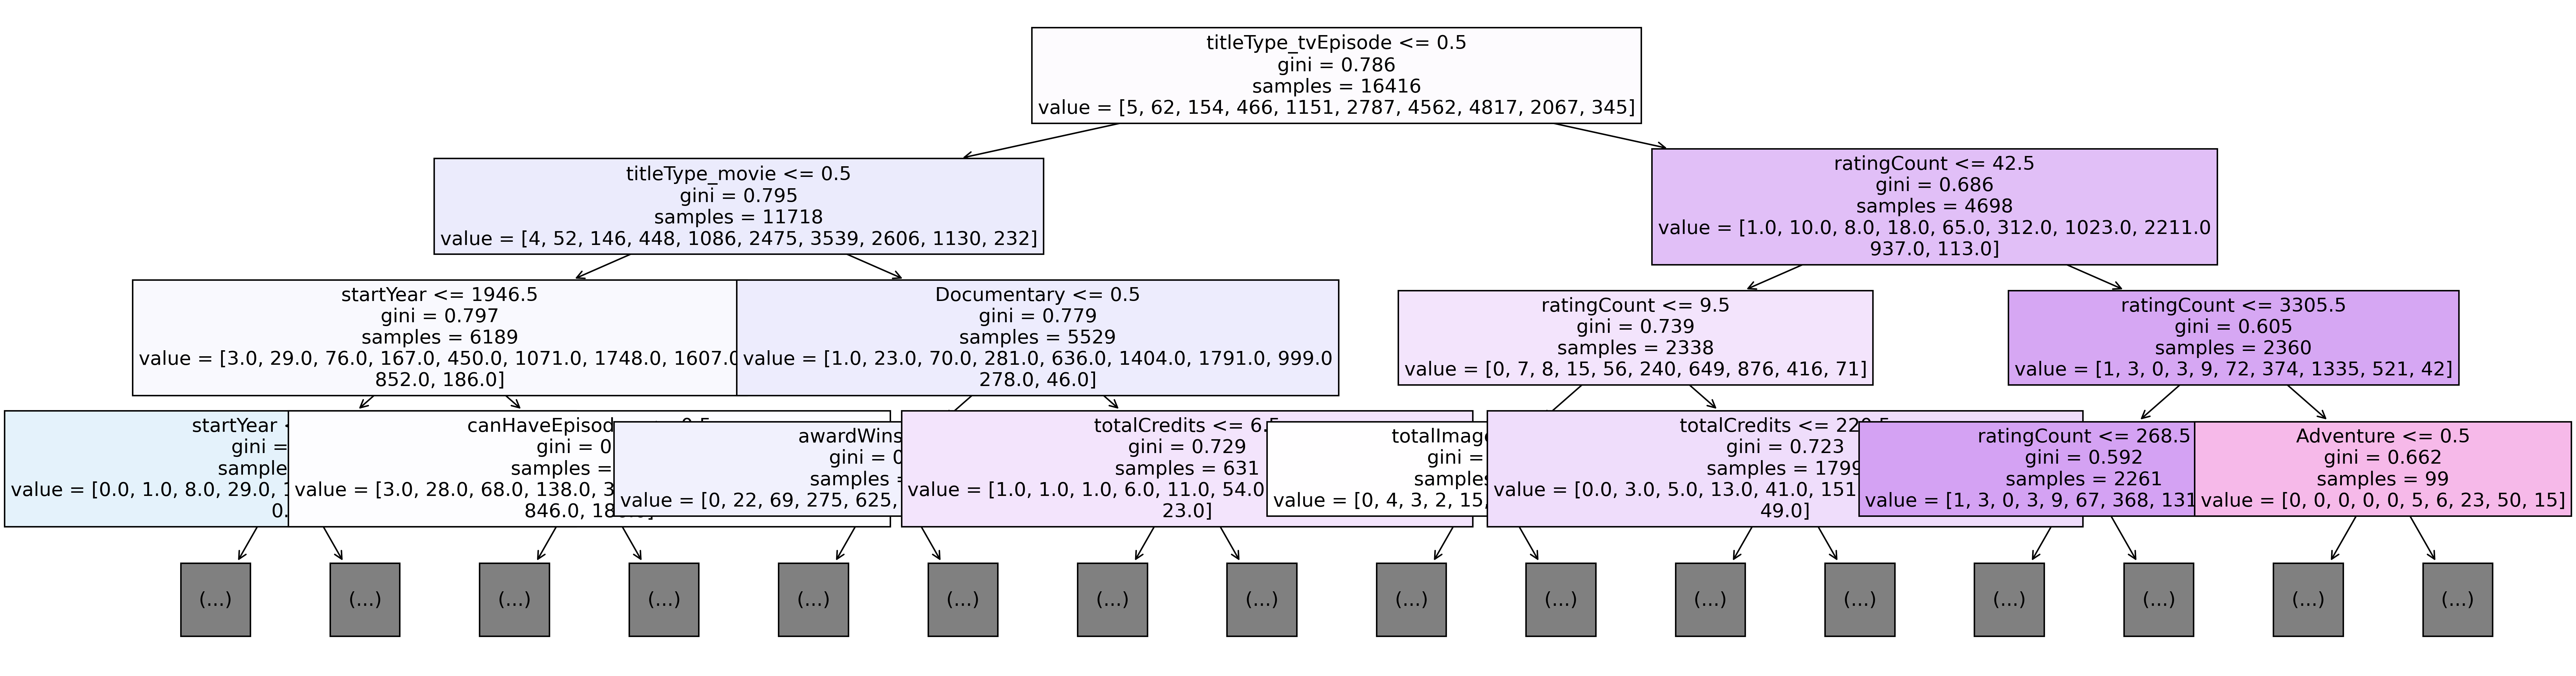

In [23]:
plt.figure(figsize=(29, 8), dpi=300)
plot_tree(dt1, feature_names=attributes, filled=True, max_depth=3, fontsize=13)
plt.show()
#mostriamo solo alcuni nodi

In [24]:
y_train_pred = dt1.predict(xtrain) #check performance
y_test_pred = dt1.predict(xtest) #measures perf on test set

In [25]:
print('Train Accuracy %s' % accuracy_score(ytrain, y_train_pred))
print('Train F1-score %s' % f1_score(ytrain, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(ytest, y_test_pred))
print('Test F1-score %s' % f1_score(ytest, y_test_pred, average=None))

Train Accuracy 0.9994517543859649
Train F1-score [1.         1.         1.         1.         0.99956541 0.99982063
 0.99923321 0.99927318 0.99951597 1.        ]

Test Accuracy 0.32673992673992674
Test F1-score [0.         0.04444444 0.06382979 0.15686275 0.21473159 0.28891258
 0.36576396 0.42023103 0.24110385 0.11711712]


In [26]:
print(classification_report(ytest, y_test_pred)) 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.04      0.05      0.04        19
           3       0.07      0.06      0.06        52
           4       0.16      0.15      0.16       155
           5       0.21      0.22      0.21       383
           6       0.29      0.29      0.29       929
           7       0.37      0.36      0.37      1516
           8       0.42      0.42      0.42      1603
           9       0.24      0.24      0.24       686
          10       0.12      0.11      0.12       116

    accuracy                           0.33      5460
   macro avg       0.19      0.19      0.19      5460
weighted avg       0.33      0.33      0.33      5460



In [27]:
# Genera il report come dizionario
report_dict = classification_report(ytest, y_test_pred, output_dict=True)

# Converti il report in un DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Converte il DataFrame in una tabella LaTeX
latex_table = report_df.to_latex(index=True, float_format="%.2f")

# Salva il risultato in un file .tex
with open("classification_report.tex", "w") as f:
    f.write(latex_table)

print("Tabella LaTeX salvata in 'classification_report.tex'")

Tabella LaTeX salvata in 'classification_report.tex'


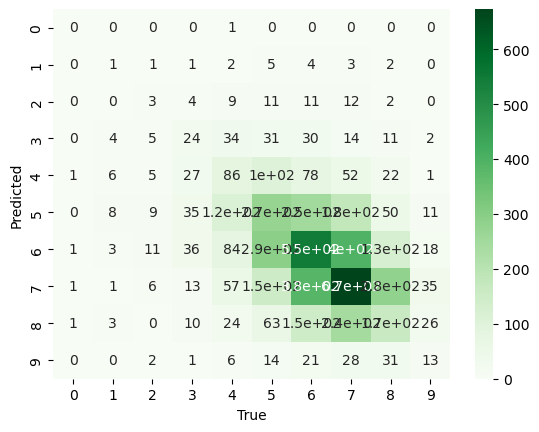

In [28]:
cf = confusion_matrix(ytest, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
#plt.savefig("conf_matrix_hasAward.png", dpi=300, bbox_inches="tight")
plt.show()

## Randomize search 

In [30]:
#list of parameter to test
param_list = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
    'criterion': ['gini', 'entropy']
}

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(), #model to initialize
    param_distributions=param_list, #parameter list to check
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1, #mode used
    refit=True, 
    n_iter=200, #max iter, not in gridsearch
    #verbose=2
)

random_search.fit(xtrain, ytrain)
clf = random_search.best_estimator_ #we can access best estimator

In [31]:
random_search.best_params_

{'min_samples_split': 100,
 'min_samples_leaf': 10,
 'max_depth': 8,
 'criterion': 'gini'}

In [32]:
%%time
#list of parameter to test
param_list = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [5, 10, 20, 50, 80, 100, 150],
    'min_samples_leaf': [10, 20, 30, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy']
}

clf = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(), #model to initialize
    param_distributions=param_list, #parameter list to check
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1, #mode used
    refit=True, 
    random_state=42,
    n_iter=100, #max iter, not in gridsearch
    #verbose=2
)

random_search.fit(xtrain, ytrain)
clf = random_search.best_estimator_ #we can access best estimator

CPU times: total: 17.5 s
Wall time: 9min 42s


In [33]:
random_search.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_depth': 8,
 'criterion': 'gini'}

In [34]:
%%time
dtr = DecisionTreeClassifier(min_samples_leaf= 1, min_samples_split= 50, max_depth= 8, criterion= 'gini')
dtr.fit(xtrain, ytrain) #fitting on train set, then use on test set

CPU times: total: 344 ms
Wall time: 468 ms


DecisionTreeClassifier(max_depth=8, min_samples_split=50)

In [35]:
y_train_pred = dtr.predict(xtrain) #check performance
y_test_pred = dtr.predict(xtest) #measures perf on test set

In [36]:
print('Train Accuracy %s' % accuracy_score(ytrain, y_train_pred))
print('Train F1-score %s' % f1_score(ytrain, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(ytest, y_test_pred))
print('Test F1-score %s' % f1_score(ytest, y_test_pred, average=None))

Train Accuracy 0.4128898635477583
Train F1-score [0.         0.         0.12021858 0.00854701 0.23737066 0.35627975
 0.44417833 0.52585757 0.13656007 0.04532578]

Test Accuracy 0.3912087912087912
Test F1-score [0.         0.         0.         0.         0.22303473 0.33685322
 0.41570178 0.51799687 0.0690571  0.01680672]


In [37]:
print(classification_report(ytest, y_test_pred)) 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00       155
           5       0.37      0.16      0.22       383
           6       0.33      0.34      0.34       929
           7       0.36      0.49      0.42      1516
           8       0.45      0.62      0.52      1603
           9       0.39      0.04      0.07       686
          10       0.33      0.01      0.02       116

    accuracy                           0.39      5460
   macro avg       0.22      0.17      0.16      5460
weighted avg       0.37      0.39      0.35      5460



C:\Users\alix2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alix2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alix2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Selecting the variable based on the feature importance

In [39]:
zipped = zip(attributes, dt1.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
#save the useless var
col_to_drop_imp=[]
for col, imp in zipped:
    #print(col, imp)
    #see what features are the most important for out model
    if imp <= 0.00010:
            col_to_drop_imp.append(col)
#print(col_to_drop_imp)
#see what features are the most important for out model
#these cols will be removed in next slot

In [40]:
#usa solo le colonne che hanno un minimo di importanza
#ovvero sopra 0.001
target= 'rating'
col_to_drop_imp += [target]
attributes = [col for col in clean_train.columns if col not in col_to_drop_imp]
xtrain= clean_train[attributes].values
ytrain = clean_train[target] #target variable
xtest= clean_test[attributes].values
ytest= clean_test[target]
#see what features are the most important for out model

## Grafici di vari hyperp. e anche overfitting

In [42]:
nodes = []
train_err = []
test_err = []

for max_depth in list(np.arange(1, 20)):
    dt = DecisionTreeClassifier(max_depth=max_depth) #avoid to grow until the end
    dt.fit(xtrain, ytrain)
    y_train_pred = dt.predict(xtrain)
    y_test_pred = dt.predict(xtest)

    train_err.append(1 - accuracy_score(ytrain, y_train_pred))
    test_err.append(1 - accuracy_score(ytest, y_test_pred))
    nodes.append(dt.tree_.node_count)

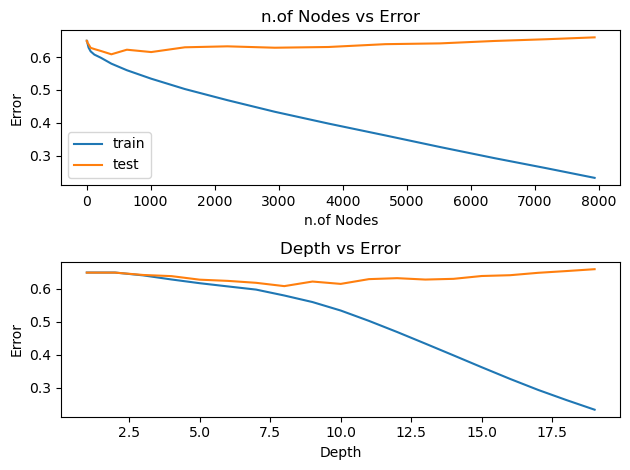

In [43]:
fig, ax = plt.subplots(2,1)
ax[0].plot(nodes, train_err, label='train')
ax[0].plot(nodes, test_err, label='test')
ax[0].legend()

ax[0].set_xlabel("n.of Nodes")
ax[0].set_ylabel("Error")
ax[0].set_title("n.of Nodes vs Error")

ax[1].plot(list(np.arange(1, 20)), train_err, label='train')
ax[1].plot(list(np.arange(1, 20)), test_err, label='test')

ax[1].set_xlabel("Depth")
ax[1].set_ylabel("Error")
ax[1].set_title("Depth vs Error")

plt.tight_layout()
# Spaziatura tra i grafici
fig.subplots_adjust(hspace=0.5)  # Aumenta la spaziatura verticale

plt.savefig("overf.png", dpi=300, bbox_inches="tight")

plt.show()
#plotting no of nodes and parameter used

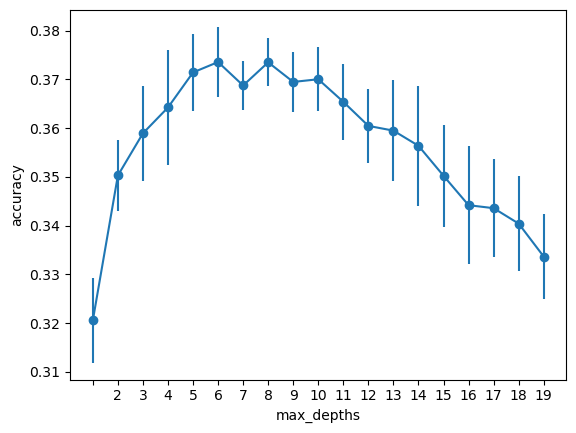

In [44]:
######no of nodes############
max_depths = [None] + list(np.arange(2, 20))
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt, xtrain, ytrain, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()
#performance and std, we can do it for the possible parameter

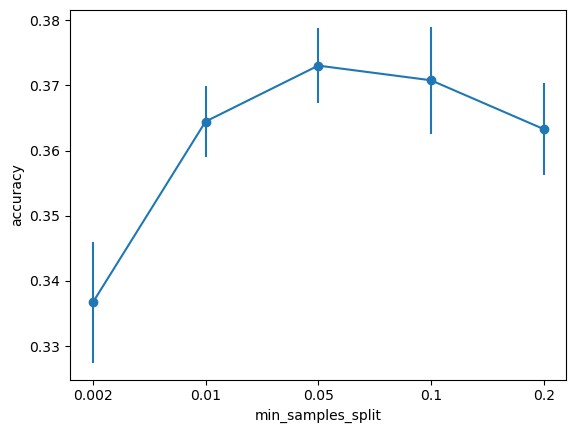

In [45]:
#######min sample split##########
min_samples_splits = [0.002, 0.01, 0.05, 0.1, 0.2]
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_val_score(dt, xtrain, ytrain, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

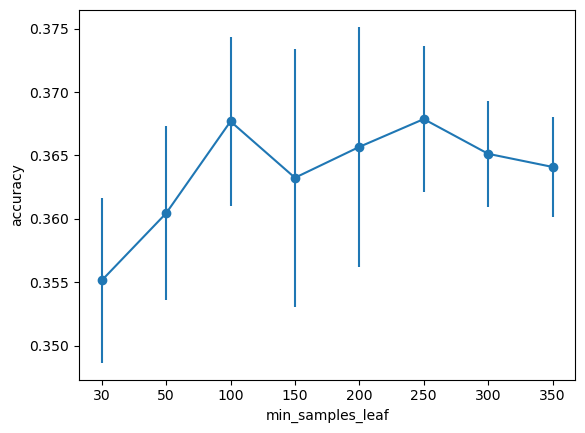

In [46]:
#######min sample leafs#######
min_samples_leafs = [ 30, 50, 100, 150, 200, 250, 300, 350]
avg_scores = list()
std_scores = list()

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    scores = cross_val_score(dt, xtrain, ytrain, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_leafs)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_leafs)), min_samples_leafs)
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.show()

In [47]:
%%time
dtf = DecisionTreeClassifier(min_samples_leaf= 100, min_samples_split= 20, max_depth= 5)
dtf.fit(xtrain, ytrain) #fitting on train set, then use on test set

CPU times: total: 125 ms
Wall time: 161 ms


DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=20)

In [48]:
y_train_pred = dtf.predict(xtrain) #check performance
y_test_pred = dtf.predict(xtest) #measures perf on test set

In [49]:
print('Train Accuracy %s' % accuracy_score(ytrain, y_train_pred))
print('Train F1-score %s' % f1_score(ytrain, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(ytest, y_test_pred))
print('Test F1-score %s' % f1_score(ytest, y_test_pred, average=None))

Train Accuracy 0.37792397660818716
Train F1-score [0.         0.         0.         0.         0.09831029 0.30524312
 0.40465199 0.51708102 0.07743071 0.        ]

Test Accuracy 0.37252747252747254
Test F1-score [0.         0.         0.         0.         0.07943925 0.32574608
 0.39686402 0.50402145 0.05652759 0.        ]


#### ccp_alphas 
Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. <br>
Sklearn decision tree offers a function that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [51]:
path = clf.cost_complexity_pruning_path(xtrain, ytrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [52]:
for alpha, imp in zip(ccp_alphas, impurities):
    print(alpha, imp)

0.0 0.6985278932173552
1.8274853801169503e-05 0.6985461680711563
2.1550087339561102e-05 0.6985677181584958
3.9595516569200734e-05 0.698607313675065
4.568713450292419e-05 0.6986530008095679
5.6515545645980476e-05 0.6987095163552139
6.645401382243492e-05 0.6987759703690364
6.80060891731371e-05 0.6988439764582095
6.931841096995356e-05 0.6989132948691794
7.817746981833682e-05 0.6989914723389977
8.448493919985148e-05 0.6990759572781976
8.905874172109984e-05 0.6991650160199187
9.055424351476983e-05 0.6992555702634334
9.575692625228235e-05 0.6993513271896857
9.74658869395713e-05 0.6994487930766253
9.888089333207062e-05 0.6995476739699574
0.00010017382953399472 0.6996478477994914
0.00010064185868279354 0.6997484896581742
0.00010706480004725634 0.6998555544582215
0.00010861213615341592 0.6999641665943749
0.00011306412073955937 0.700190294835854
0.00011378563942248689 0.7003040804752765
0.00011583006065179222 0.7004199105359282
0.00011748120300751879 0.7005373917389357
0.00012049759856777413 0.7

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

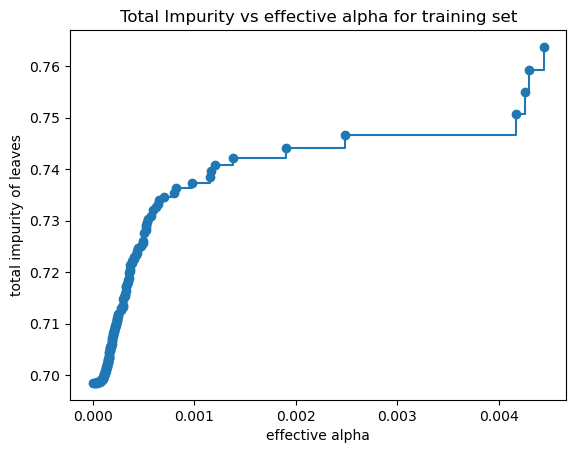

In [53]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [54]:
random_search.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_depth': 8,
 'criterion': 'gini'}

In [55]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **random_search.best_params_)
    clf.fit(xtrain, ytrain)
    clfs.append(clf)
    
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.022029405147197756


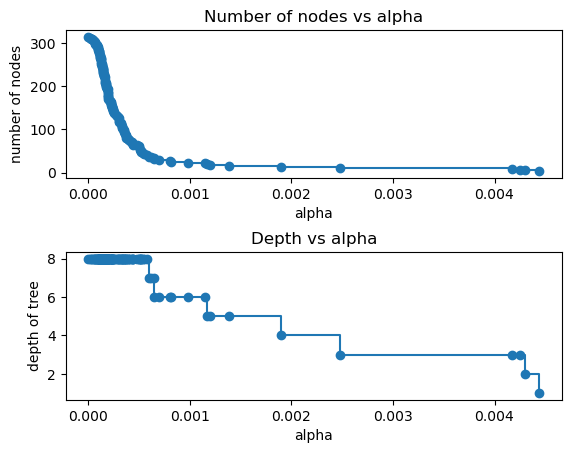

In [56]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)

# Primo grafico
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

# Secondo grafico
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")

# Spaziatura tra i grafici
fig.subplots_adjust(hspace=0.5)  # Aumenta la spaziatura verticale

# Salvataggio dell'immagine
plt.savefig("ccpalphas.png", dpi=300, bbox_inches="tight")


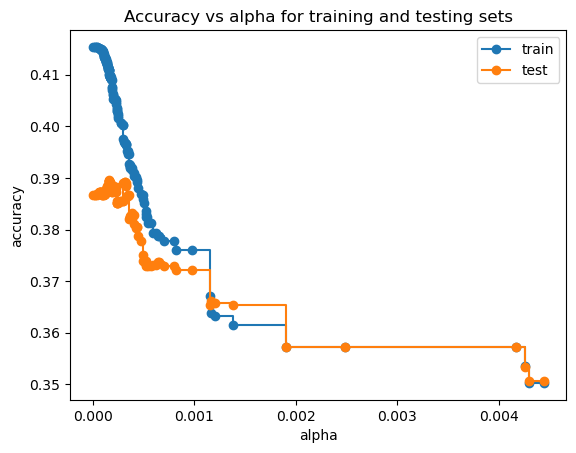

In [57]:
train_scores = [clf.score(xtrain, ytrain) for clf in clfs]
test_scores = [clf.score(xtest, ytest) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [58]:
from sklearn.model_selection import GridSearchCV

# Lista di possibili valori di ccp_alpha
param_grid = {'ccp_alpha': ccp_alphas}

# Grid search per trovare il miglior ccp_alpha
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5)
grid_search.fit(xtrain, ytrain)

print("Miglior valore di ccp_alpha:", grid_search.best_params_)


Miglior valore di ccp_alpha: {'ccp_alpha': 0.00034981294001143644}


In [59]:
dtcc = DecisionTreeClassifier(ccp_alpha=0.0003294971701076478)
dtcc.fit(xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0003294971701076478)

In [60]:
y_test_pred = dtcc.predict(xtest)

In [61]:
print('Train Accuracy %s' % accuracy_score(ytrain, y_train_pred))
print('Train F1-score %s' % f1_score(ytrain, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(ytest, y_test_pred))
print('Test F1-score %s' % f1_score(ytest, y_test_pred, average=None))

Train Accuracy 0.37792397660818716
Train F1-score [0.         0.         0.         0.         0.09831029 0.30524312
 0.40465199 0.51708102 0.07743071 0.        ]

Test Accuracy 0.38974358974358975
Test F1-score [0.         0.         0.         0.         0.1969697  0.31506059
 0.40071238 0.52581489 0.06182796 0.        ]


In [62]:
y_test_pred = dtcc.predict(xtest)
print("Accuracy:", accuracy_score(ytest, y_test_pred))

Accuracy: 0.38974358974358975


In [63]:
print(classification_report(ytest, y_test_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00       155
           5       0.36      0.14      0.20       383
           6       0.34      0.29      0.32       929
           7       0.36      0.45      0.40      1516
           8       0.42      0.69      0.53      1603
           9       0.40      0.03      0.06       686
          10       0.00      0.00      0.00       116

    accuracy                           0.39      5460
   macro avg       0.19      0.16      0.15      5460
weighted avg       0.36      0.39      0.34      5460



C:\Users\alix2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alix2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alix2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


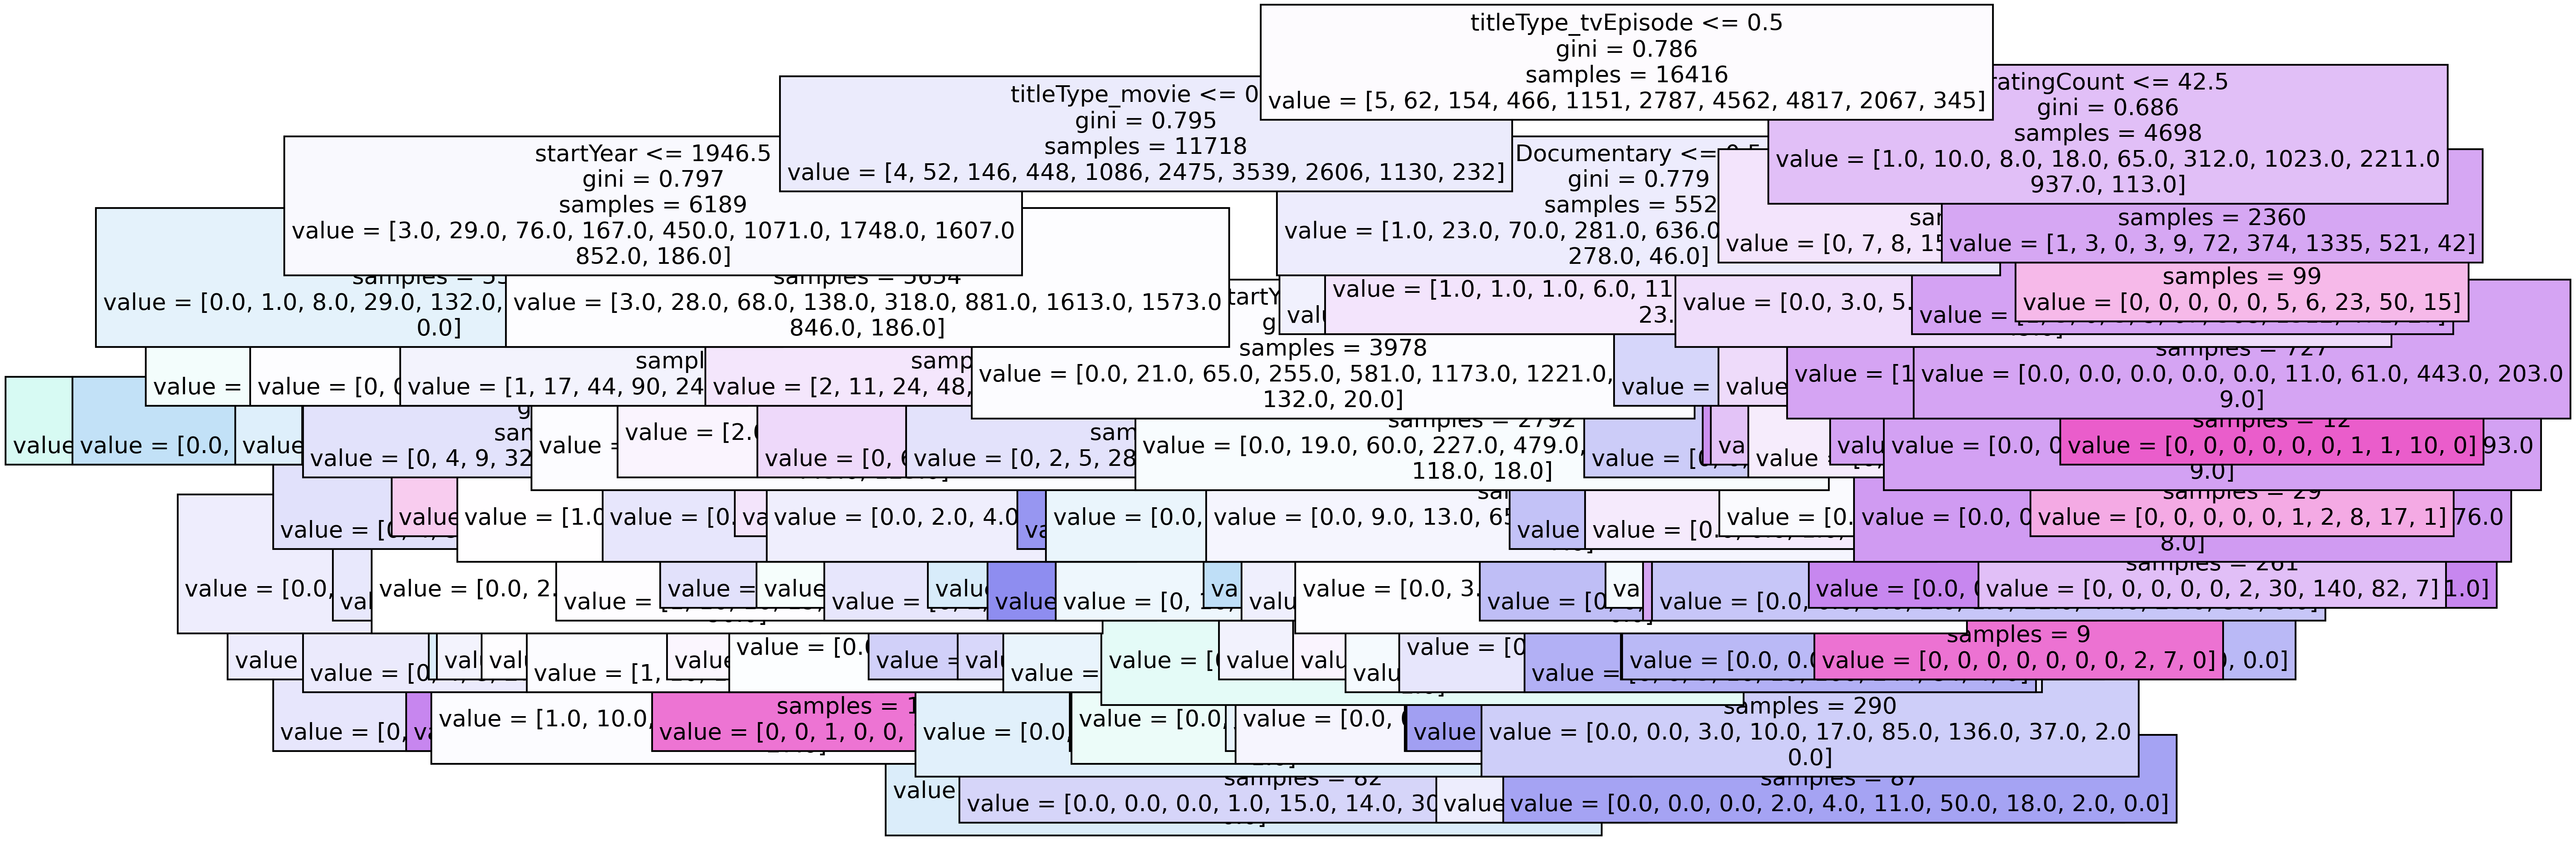

In [64]:
plt.figure(figsize=(20, 8), dpi=300)
plot_tree(dtcc, feature_names=attributes, filled=True, max_depth=15, fontsize=13)
plt.show()

## Pruning Utils

In [66]:
def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and
            inner_tree.children_right[index] == TREE_LEAF)


def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        # print("Pruned {}".format(index))


def prune_duplicate_leaves(dt):
    # Remove leaves if both
    decisions = dt.tree_.value.argmax(axis=2).flatten().tolist()  # Decision for each node
    prune_index(dt.tree_, decisions)

In [94]:
 dtpr = DecisionTreeClassifier(min_samples_split= 10, min_samples_leaf= 10, max_depth= 8, criterion= 'gini')

In [96]:
dtpr.fit(xtrain, ytrain)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=10)

In [98]:
print('Train Accuracy %s' % accuracy_score(ytrain, y_train_pred))
print('Train F1-score %s' % f1_score(ytrain, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(ytest, y_test_pred))
print('Test F1-score %s' % f1_score(ytest, y_test_pred, average=None))

Train Accuracy 0.37792397660818716
Train F1-score [0.         0.         0.         0.         0.09831029 0.30524312
 0.40465199 0.51708102 0.07743071 0.        ]

Test Accuracy 0.38974358974358975
Test F1-score [0.         0.         0.         0.         0.1969697  0.31506059
 0.40071238 0.52581489 0.06182796 0.        ]


In [100]:
print(classification_report(ytest, y_test_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00       155
           5       0.36      0.14      0.20       383
           6       0.34      0.29      0.32       929
           7       0.36      0.45      0.40      1516
           8       0.42      0.69      0.53      1603
           9       0.40      0.03      0.06       686
          10       0.00      0.00      0.00       116

    accuracy                           0.39      5460
   macro avg       0.19      0.16      0.15      5460
weighted avg       0.36      0.39      0.34      5460



C:\Users\alix2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alix2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alix2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


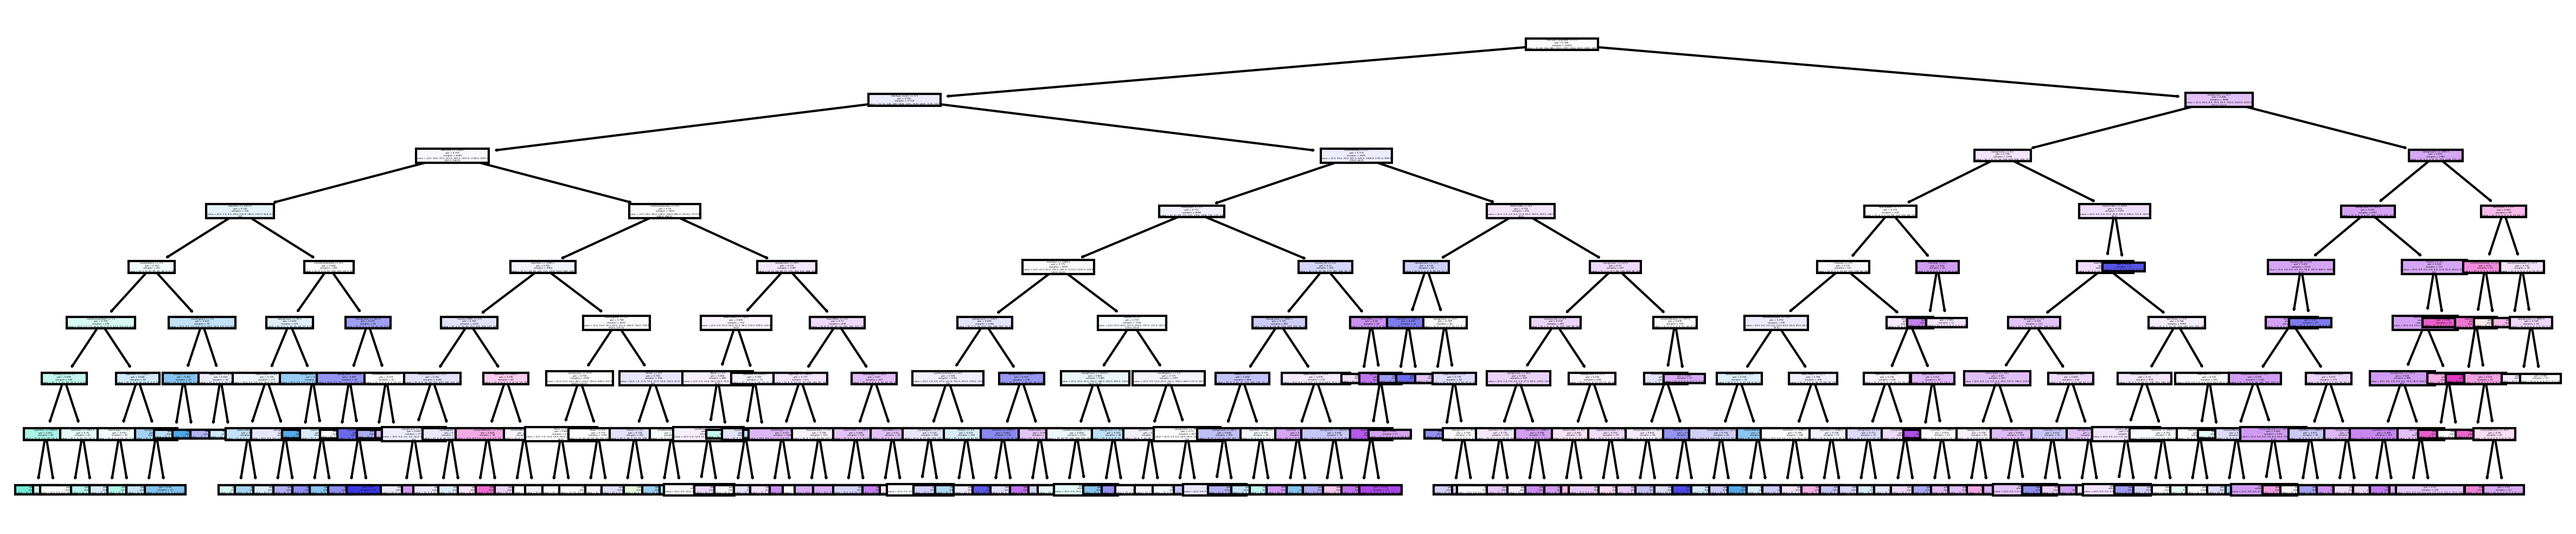

In [102]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dtpr, feature_names=attributes, filled=True)
plt.show()

In [103]:
prune_duplicate_leaves(dtpr)
#now visualize after pruning

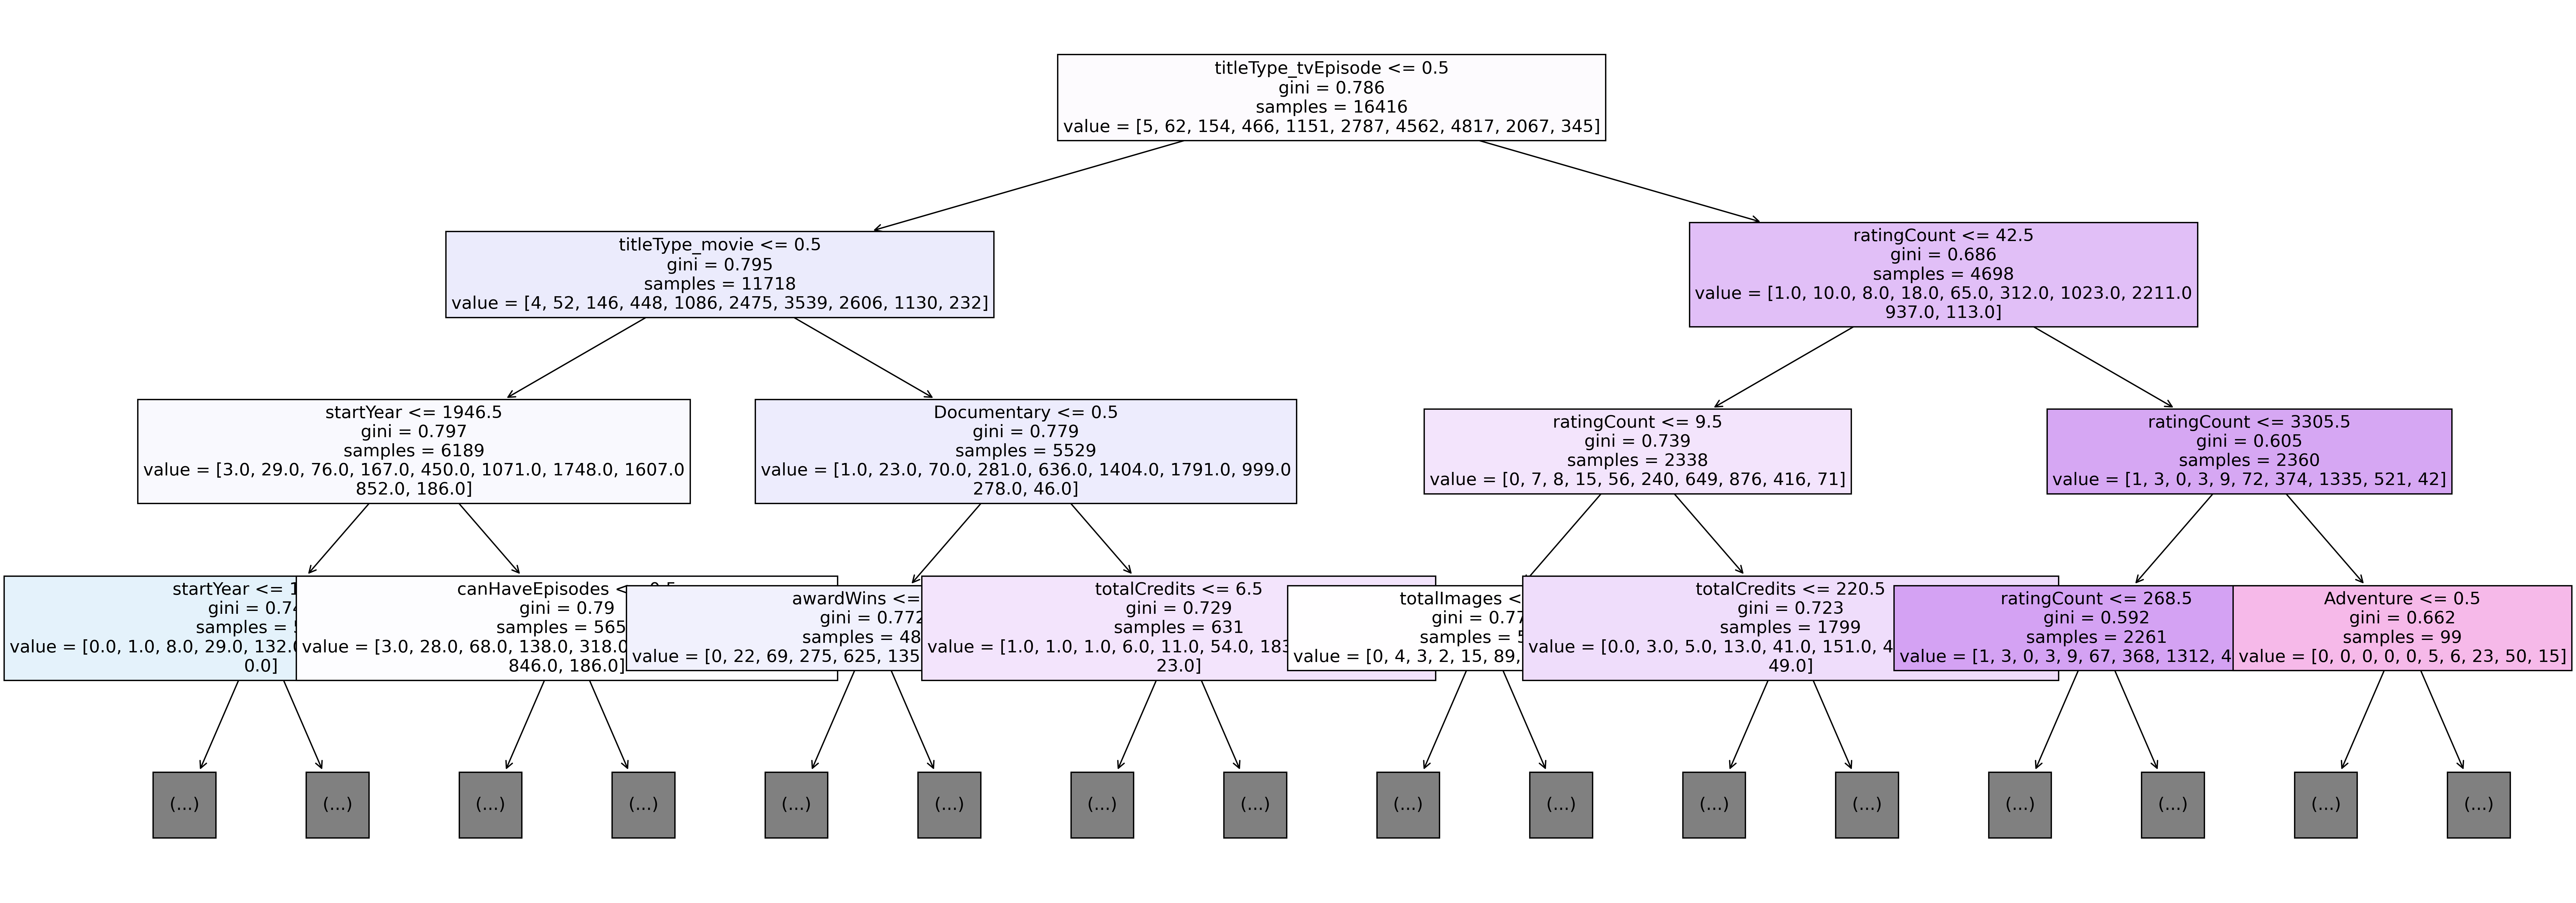

In [126]:
plt.figure(figsize=(33, 12), dpi=300)
plot_tree(dtpr, feature_names=attributes, filled=True, max_depth=3, fontsize=13)
plt.savefig("tree.png", dpi=300, bbox_inches="tight")
plt.show()